# Representing an EO data cube

An EO data cube stores and organizes EO data, and possibly also additional data from other sources (e.g. a digital surface model). It falls entirely within the image domain of the framework and is constructed and managed by a software expert.

This notebook describes the data structures to represent an EO data cube in semantique, and how to interact with it.

## Content

- [Structure](#Structure)
- [The Opendatacube configuration](#The-Opendatacube-configuration)
- [The Geotiffarchive configuration](#The-Geotiffarchive-configuration)

## Prepare

Import packages:

In [1]:
import semantique as sq

In [2]:
import geopandas as gpd
import json

## Structure

There is not a single standard on how an EO data cube should be implemented in practice. Many approaches exist, which we refer to as different *configurations* of an EO data cube. The structure of semantique is flexible and does not put any limitations on what the configuration of an EO data cube should be. Instead, it allows expert users to create their own class that represents their specific EO data cube configuration. Such a class should always inherit from the abstract base class [Datacube](https://zgis.github.io/semantique/semantique.datacube.Datacube.html) that semantique contains. Such a base class can be seen as a blueprint for any object that represents an EO data cube. Do note that an EO data cube representation in semantique never contains the data values of the cube themselves. Instead, it will have some property that allows the retriever to access the actual storage location. How this property looks like will depend on the configuration of the EO data cube.

In [3]:
base = sq.datacube.Datacube()

To ensure interoperability, an EO data cube representation of any configuration is required to contain two standard elements. The first one is the layout, which is generally provided when initializing an instance of an EO data cube class and stored inside the [layout](https://zgis.github.io/semantique/semantique.datacube.Datacube.layout.html) property. The layout is a repository containing a description of the content of the EO data cube. Each distinct data layer in the cube (e.g. the different spectral bands) should be described by a dedicated metadata object in the layout that can be indexed by a unique name assigned to that layer. This metadata object provides information about the values in the layer, but also about where it can be found inside the structure of the cube. In semantique, the layout is always expected to have the structure of a Python dictionary. In this dictionary, the names of data layers are the keys and the metadata objects (which themselves are a dictionary as well) are the values. The dictionary may have a nested structure formalizing a categorization of data layers, e.g. the metadata object of the data layer "blue band" can be indexed by the key pair ("reflectance", "blue band") instead of only "blue band".

In [4]:
hasattr(base, "layout")

True

The second required element is the retriever function, which should be implemented as the [retrieve()](https://zgis.github.io/semantique/semantique.datacube.Datacube.retrieve.html) method of an EO data cube class. The retriever is an interface that exposes the content of the EO data cube to the other components in the querying framework. Given a textual reference to a data layer and a spatio-temporal extent, it is able to retrieve the corresponding data values from the cube, and return them in a three-dimensional, spatio-temporal array. The exact implementation of the retriever depends on the configuration of the EO data cube, but the inputs it accepts and the output it returns does not. Hence, the retriever serves as a standardized API that allows other components of the framework to access the content of the EO data cube independent from its configuration.

In [5]:
hasattr(base, "retrieve")

True

It is important to note here that when evaluating a query recipe the query processor does not care at all what the configuration of the EO data cube is and how it retrieves data. It only interacts with the retriever function, and thus only cares about what input the retriever function accepts, and in what format it returns the retrieved data.

## The Opendatacube configuration

Through the [Opendatacube](https://zgis.github.io/semantique/semantique.datacube.Opendatacube.html) sub-class semantique has built-in support for EO data cubes that are deployed using the [Open Data Cube software](https://www.opendatacube.org/). It contains a retriever that knows how to interact with the Python API of Open Data Cube.

To initialize a representation of such a data cube, you need to provide a valid layout dictionary and a [Datacube object](https://opendatacube.readthedocs.io/en/latest/api/core-classes/datacube.html) that allows the retriever to interact with the actual data storage. A valid layout for this configuration means that the metadata objects for each data layer should contain at least the following keys and values:

- `name`: The name of the data layer inside the Open Data Cube. In Open Data Cube terminology this is called the measurement.
- `product`: The [product](https://opendatacube.readthedocs.io/en/latest/about-core-concepts/products.html) in which the data layer is stored inside the Open Data Cube.
- `type`: The value type of the values in the data layer. There are no limits to what the value type categorization should be. If it differs from the [semantique value types](processor.ipynb#Tracking-value-types), this needs to be mapped through a configuration parameter when initializing the instance, see below.
- `values`: An overview of the values in the data layer. If the values are numerical, this should be a dictionary containing the keys "min", "max" and "precision". If the values are categorical, this should be a list of dictionaries, with each dictionary referring to single category and containing the keys "id", "label" and "description".

When initializing the instance, you should also provide the timezone in which the temporal coordinates inside the data cube are stored. By default, semantique assumes this is [UTC](https://en.wikipedia.org/wiki/Coordinated_Universal_Time). Additionaly, you can provide several configuration parameters that tune the data retrieval process, see the [documentation](https://zgis.github.io/semantique/semantique.datacube.Opendatacube.html) of the Opendatacube class for details.

Since we do not have an Open Data Cube running in our semantique development environment, nor have a Open Data Cube layout file stored inside the package, we can not show code that initializes and interacts with a Opendatacube instance. However, the following code snippet should give an indication:

```python
import datacube
import json
import semantique as sq

odc_obj = datacube.Datacube()

with open("somedir/layout.json", "r") as file:
    dc = sq.datacube.Opendatacube(json.load(file), connection = odc_obj)
```

## The Geotiffarchive configuration

Besides the Opendatacube configuration, semantique contains a second built-in EO data cube configuration called [Geotiffarchive](https://zgis.github.io/semantique/semantique.datacube.Geotiffarchive.html). This configuration is targeted at small data cubes that are nothing more than a zipped archive of multiple GeoTIFF files, each having two spatial and one temporal dimension. Given the nature of GeoTIFF, the time dimension will be recognized as "band dimension", and therefore the time coordinates should be stored as band description for each band. Be aware that the Geotiffarchive configuration in semantique is mainly meant for demonstration purposes, and the retriever function is not optimized for performance (e.g. the full GeoTIFF is loaded into memory before subsetting in space and time).

To initialize a representation of a Geotiffarchive data cube, you need to provide a valid layout dictionary and the filepath to the zipped archive of GeoTIFF files. A valid layout for this configuration means that the metadata objects for each data layer should contain at least the following keys and values:

- `file`: The filename of the GeoTIFF file in which the values for the data layer are stored.
- `type`: The value type of the values in the data layer. There are no limits to what the value type categorization should be. If it differs from the [semantique value types](processor.ipynb#Tracking-value-types), this needs to be mapped through a configuration parameter when initializing the instance, see below.
- `values`: An overview of the values in the data layer. If the values are numerical, this should be a dictionary containing the keys "min", "max" and "precision". If the values are categorical, this should be a list of dictionaries, with each dictionary referring to single category and containing the keys "id", "label" and "description".

When initializing the instance, you should also provide the timezone in which the temporal coordinates inside the data cube are stored. By default, semantique assumes this is [UTC](https://en.wikipedia.org/wiki/Coordinated_Universal_Time). Additionaly, you can provide several configuration parameters that tune the data retrieval process, see the [documentation](https://zgis.github.io/semantique/semantique.datacube.Geotiffarchive.html) of the Geotiffarchive class for details.

Now we can initialize an instance of the Geotiffarchive class using the small demo data cube that is contained in semantique. The layout file we use looks like [this](files/layout.json).

In [6]:
with open("files/layout.json", "r") as file:
    dc = sq.datacube.GeotiffArchive(json.load(file), src = "files/layers.zip")

In [7]:
isinstance(dc, sq.datacube.Datacube)

True

To interact with the retriever, we need to provide an array that specifies the spatio-temporal extent inside which the requested data should be retrieved.

In [8]:
from semantique.processor.utils import parse_extent

In [9]:
space = sq.SpatialExtent(gpd.read_file("files/footprint.geojson"))
time = sq.TemporalExtent("2019-01-01", "2020-12-31")

extent = parse_extent(space, time, spatial_resolution = [-10, 10], crs = 3035)

In [10]:
colortype = dc.retrieve("appearance", "colortype", extent = extent)

In [11]:
colortype

<xarray.DataArray 'colortype' (time: 3, y: 563, x: 576)>
array([[[29., 29., 29., ..., 29., 29., 29.],
        [29., 29., 29., ..., 29., 29., 29.],
        [29., 29., 29., ...,  5., 29., 29.],
        ...,
        [ 5.,  5.,  5., ..., 29., 29., 29.],
        [ 5.,  5.,  5., ..., 29., 29., 29.],
        [ 5., 29., 29., ..., 29., 29., 29.]],

       [[ 4.,  4.,  4., ...,  4.,  1.,  1.],
        [ 6.,  4.,  4., ...,  3.,  1.,  4.],
        [ 6.,  4.,  4., ...,  4.,  4.,  4.],
        ...,
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

       [[21., 21., 21., ...,  4.,  5.,  4.],
        [21., 21., 21., ...,  3.,  6.,  4.],
        [21., 21., 21., ...,  3.,  4.,  4.],
        ...,
        [ 3.,  3.,  3., ...,  3., 27., 27.],
        [ 3., 27.,  3., ..., 27., 27., 27.],
        [27.,  3.,  7., ..., 27., 27., 27.]]])
Coordinates:
  * x              (x) float64 4.53e+06 4.53e+06 ... 4.536e+06 4.536e+06
  * y              (y) float64 2.697e+06 2.697e+06 ... 2.691e+06 2.691e+06
    spatial_ref    int64 0
  * time           (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-...
    temporal_ref   int64 0
    spatial_feats  (y, x) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     1.7976931348623157e+308
    value_type:     ordinal
    value_labels:   {1: 'SVHNIR', 2: 'SVLNIR', 3: 'AVHNIR', 4: 'AVLNIR', 5: '...

In [12]:
colors = {
    "Strong vegetation with high NIR": "darkgreen",
    "Strong vegetation with low NIR": "forestgreen",
    "Average vegetation with high NIR": "limegreen",
    "Average vegetation with low NIR": "mediumseagreen",
    "Weak vegetation": "springgreen",
    "Shadow area with vegetation": "palegreen",
    "Shrub Rangeland with High NIR": "darkgoldenrod",
    "Shrub Rangeland with Low": "goldenrod",
    "Herbaceous Rangeland": "gold",
    "Weak Rangeland": "khaki",
    "Pit or bog": "olive",
    "Greenhouse": "yellowgreen",
    "Very bright barren land or built-up": "darkred",
    "Bright barren land or built-up": "firebrick",
    "Strong barren land or built-up": "red",
    "Average barren land or built-up": "tomato",
    "Dark barren land or built-up": "salmon",
    "Weak barren land or Shadow area with Barren Land": "lightsalmon",
    "Near InfraRed-Peaked Barren land and Built-up": "coral",
    "Burned area": "yellow",
    "Deep water or shadow": "dodgerblue",
    "Shallow water or shadow": "deepskyblue",
    "Turbid water or shadow": "lightskyblue",
    "Salty Shallow Water": "lightblue",
    "Cloud": "lightgrey",
    "Smoke plume": "dimgrey",
    "Thin clouds over vegetation": "aquamarine",
    "Thin clouds on water area or Barren land or Built-up areas": "paleturquoise",
    "Snow or water ice": "snow",
    "Snow shadow": "mistyrose",
    "Shadow areas": "slategrey",
    "Flame": "plum",
    "Unknown": "black",    
}

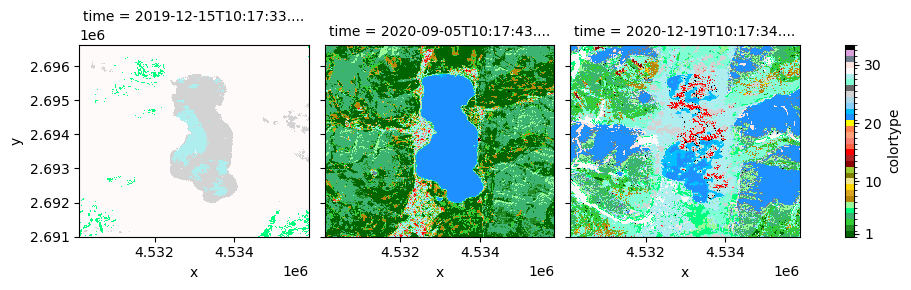

In [13]:
values = list(range(1, 34))
levels = [x - 0.5 for x in values + [max(values) + 1]]
legend = {"ticks": [1, 10, 20, 30], "label": "colortype"}
colortype.plot(x = "x", y = "y", col = "time", levels = levels, colors = list(colors.values()), cbar_kwargs = legend)